# Predicting house price with sklearn

A competition project from Kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/)

Let's get started!

Uncomment and run the cell below to install the Libararies we are going to use in this notebook. Skip if you have them already.

In [79]:
#!pip install -U scikit-learn
#!pip install lightgbm

In [82]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy import stats, special
import seaborn
import lightgbm
from sklearn import preprocessing, model_selection, gaussian_process
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import StackingRegressor as SR
from sklearn.ensemble import ExtraTreesRegressor as ETR
from sklearn import metrics, linear_model
from sklearn.pipeline import make_pipeline
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

Load the training dataset and see what are the features does it have

In [2]:
train = pd.read_csv('train.csv')

Remove the first column (house Ids). Let see what percentage of data are missing in each column and drop the ones that have too many missing values

In [3]:
train.drop('Id', axis=1, inplace=True)
num_train = train.shape[0]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Let's see how some of features are correlated with the sale price

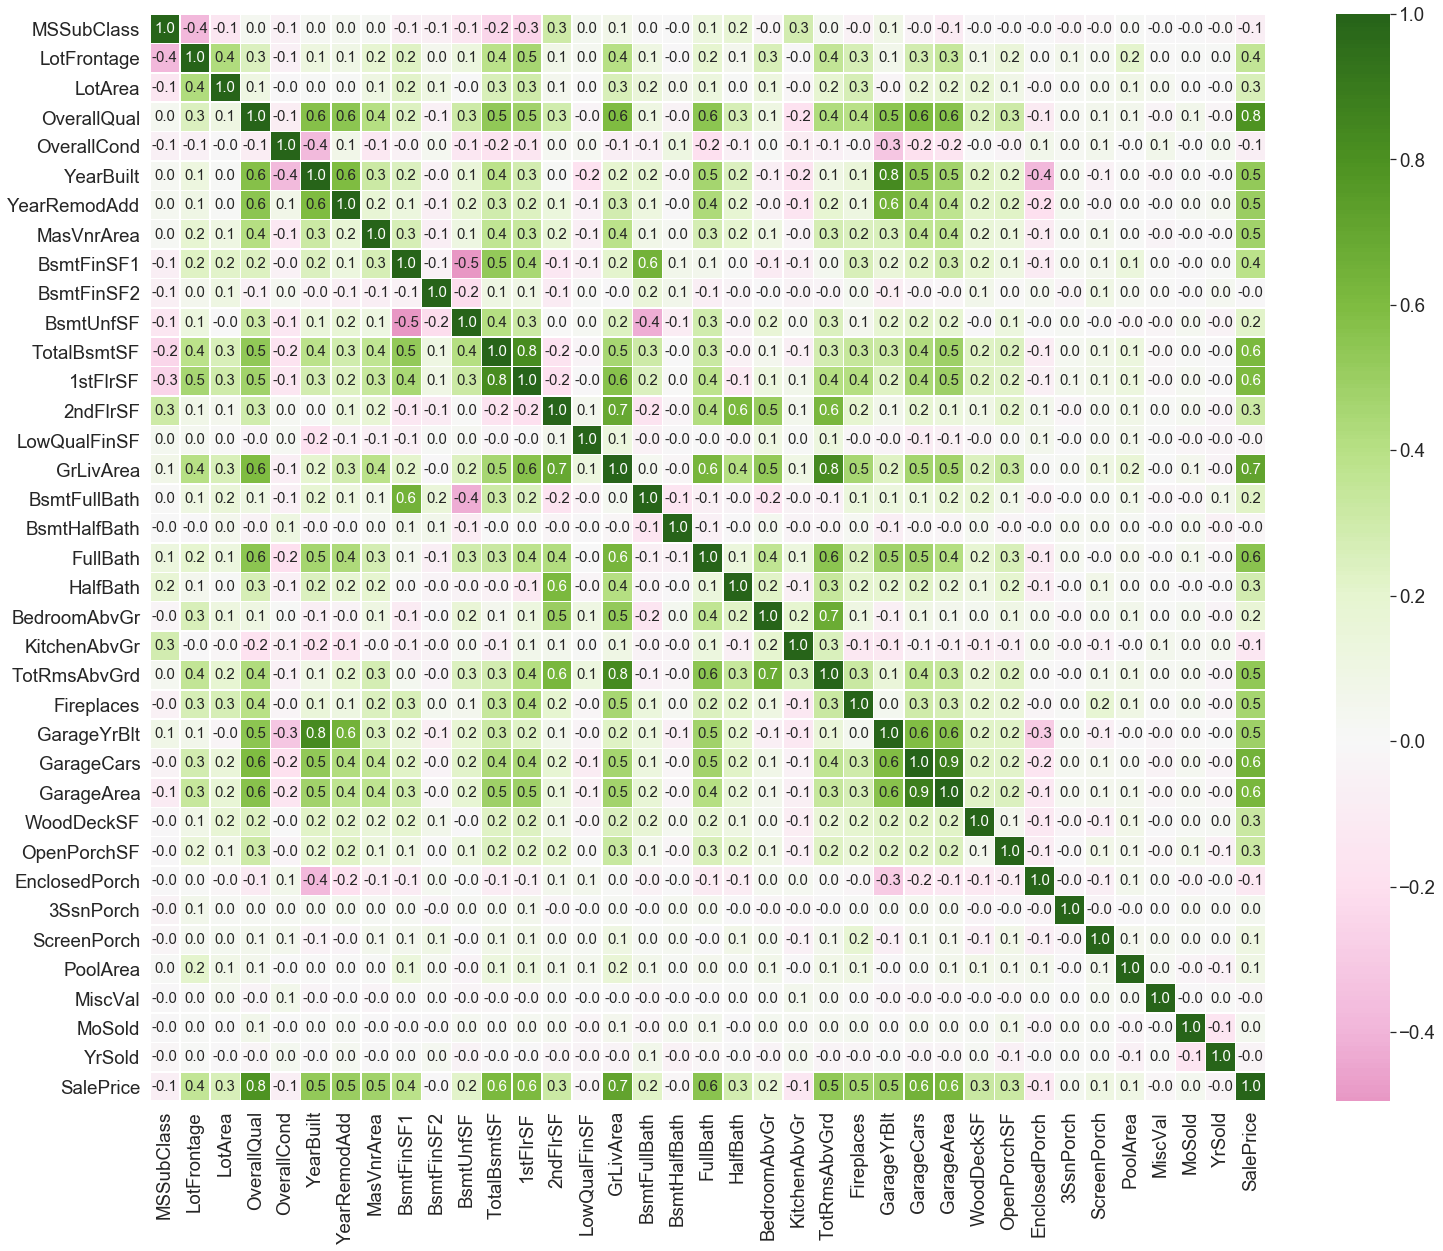

In [4]:
fig = plt.figure(figsize=(25,20))

seaborn.set(font_scale=1.7)
seaborn.heatmap(train.corr(), cmap='PiYG', annot=True, annot_kws={"size":15}, 
                center=0.0, fmt='.1f', linewidths=0.5);

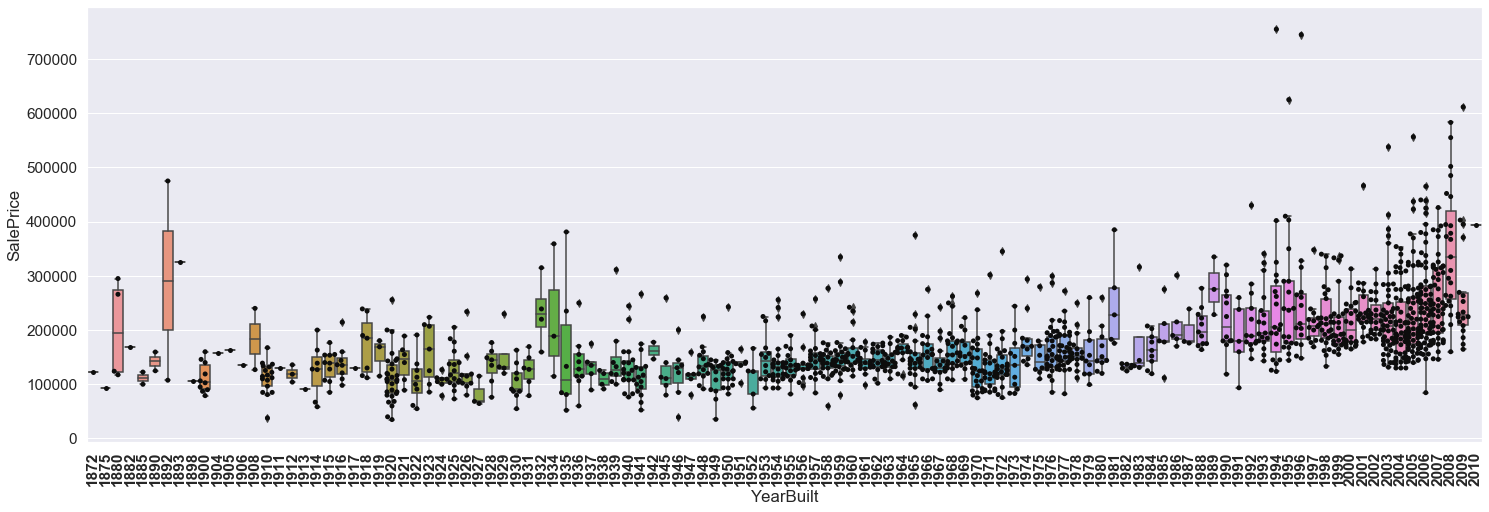

In [6]:
fig = plt.figure(figsize=(25, 8))

seaborn.set(font_scale=1.4)
seaborn.boxplot(x=train.YearBuilt, y=train.SalePrice)
seaborn.swarmplot(x=train.YearBuilt, y=train.SalePrice, color='.05')
plt.xticks(weight='bold', rotation=90);

Load test data and concatenate it to the train dataset

In [5]:
test = pd.read_csv('test.csv')

test_ids = test.Id
test.drop('Id', axis=1, inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [6]:
df = pd.concat([train, test], axis=0, sort=False)

Let's drop the missing values and create some **new features**

In [7]:
df['LotFrontage'] = df['LotFrontage'].fillna(df.groupby('1stFlrSF')['LotFrontage'].transform('mean'))
df['LotFrontage'].interpolate(method='linear',inplace=True)
df['LotFrontage'] = df['LotFrontage'].astype(int)

df['MasVnrArea'] = df['MasVnrArea'].fillna(df.groupby('MasVnrType')['MasVnrArea'].transform('mean'))
df['MasVnrArea'].interpolate(method='linear',inplace=True)
df['MasVnrArea'] = df['MasVnrArea'].astype(int)

df["Fence"] = df["Fence"].fillna("None")
df["MiscFeature"] = df["MiscFeature"].fillna("None")
df["Alley"] = df["Alley"].fillna("None")
df["PoolQC"] = df["PoolQC"].fillna("None")
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
df.loc[df['Fireplaces']==0,'FireplaceQu']='Nothing'
df.loc[df['BsmtFinSF1']==0,'BsmtFinType1']='Unf'
df.loc[df['BsmtFinSF2']==0,'BsmtQual']='TA'
df['old_house'] = df['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)
df['YrBltRmd'] = df['YearBuilt'] + df['YearRemodAdd']
df['Total_Bath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
df['Total_Square_Feet'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
df['Total_Porch_Area'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
df['exists_pool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['exists_bsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['exists_fireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df['exists_garage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

for i in df.columns:
    if 'SalePrice' not in i:
        if 'object' in str(df[str(i)].dtype):
            df[str(i)] = df[str(i)].fillna(method='ffill')
            
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         2919 non-null   int64  
 1   MSZoning           2919 non-null   object 
 2   LotFrontage        2919 non-null   int64  
 3   LotArea            2919 non-null   int64  
 4   Street             2919 non-null   object 
 5   Alley              2919 non-null   object 
 6   LotShape           2919 non-null   object 
 7   LandContour        2919 non-null   object 
 8   Utilities          2919 non-null   object 
 9   LotConfig          2919 non-null   object 
 10  LandSlope          2919 non-null   object 
 11  Neighborhood       2919 non-null   object 
 12  Condition1         2919 non-null   object 
 13  Condition2         2919 non-null   object 
 14  BldgType           2919 non-null   object 
 15  HouseStyle         2919 non-null   object 
 16  OverallQual        2919 

Some features are numeric and the others are categorical. Let identify the type of each feature and replace missing values in the numeric columns with its average. We can also replace missing categorical values with a random caegory. Obviously, this is something to tune to obtain the most optimal performance.

We are going to replace categorical features with numeric values. `LabelEncoder` can be used to normalize labels.

In [8]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
           'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
           'YrSold', 'MoSold', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 
           'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 
           'CentralAir', 'MSSubClass', 'OverallCond')

for col in columns:
    lbl_enc = preprocessing.LabelEncoder() 
    lbl_enc.fit(list(df[col].values)) 
    df[col] = lbl_enc.transform(list(df[col].values))
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         2919 non-null   int64  
 1   MSZoning           2919 non-null   object 
 2   LotFrontage        2919 non-null   int64  
 3   LotArea            2919 non-null   int64  
 4   Street             2919 non-null   int64  
 5   Alley              2919 non-null   int64  
 6   LotShape           2919 non-null   int64  
 7   LandContour        2919 non-null   object 
 8   Utilities          2919 non-null   object 
 9   LotConfig          2919 non-null   object 
 10  LandSlope          2919 non-null   int64  
 11  Neighborhood       2919 non-null   object 
 12  Condition1         2919 non-null   object 
 13  Condition2         2919 non-null   object 
 14  BldgType           2919 non-null   object 
 15  HouseStyle         2919 non-null   object 
 16  OverallQual        2919 

Some features are highly skewed

In [9]:
numerics = df.dtypes[df.dtypes != "object"].index
skewed = df[numerics].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
highly_skewed = skewed[abs(skewed) > 1].index
print(highly_skewed)

Index(['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF',
       '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage',
       '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive',
       'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street',
       'PoolQC'],
      dtype='object')


In [10]:
for feature in highly_skewed :
    df[feature] = special.boxcox1p(df[feature], stats.boxcox_normmax(df[feature] + 1))

/Users/sayedmahmoodhoseinifaradonbeh/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/sayedmahmoodhoseinifaradonbeh/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [11]:
df.interpolate(method='linear', inplace=True)

le = preprocessing.LabelEncoder()
for col in df.columns :
    if df[col].dtype == object :
        df[col] = df[col].astype(str) 
        le.fit(df[col])
        df[col] = le.transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         2919 non-null   int64  
 1   MSZoning           2919 non-null   int64  
 2   LotFrontage        2919 non-null   float64
 3   LotArea            2919 non-null   float64
 4   Street             2919 non-null   float64
 5   Alley              2919 non-null   int64  
 6   LotShape           2919 non-null   int64  
 7   LandContour        2919 non-null   int64  
 8   Utilities          2919 non-null   int64  
 9   LotConfig          2919 non-null   int64  
 10  LandSlope          2919 non-null   float64
 11  Neighborhood       2919 non-null   int64  
 12  Condition1         2919 non-null   int64  
 13  Condition2         2919 non-null   int64  
 14  BldgType           2919 non-null   int64  
 15  HouseStyle         2919 non-null   int64  
 16  OverallQual        2919 

Z-score all the features except the `SalePrice` column

In [12]:
for colname in df.columns:
    if colname != 'SalePrice':
        df[colname] = (df[colname] - df[colname].mean())/df[colname].std()
    
df.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SalePrice,old_house,YrBltRmd,Total_Bath,Total_Square_Feet,Total_Porch_Area,exists_pool,exists_bsmt,exists_fireplace,exists_garage
count,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,...,2919.000000,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03,2.919000e+03
mean,5.665218e-17,2.243219e-16,-1.090949e-14,6.055213e-15,4.175170e-13,5.014878e-16,5.342306e-16,-4.450020e-16,3.682011e-16,-1.819564e-16,...,164216.322713,2.160352e-16,4.884487e-15,-1.341662e-16,1.970941e-16,5.876385e-15,2.806936e-17,3.523919e-13,-6.994519e-16,4.865736e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,58607.980516,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.819611e-01,-4.596574e+00,-2.773711e+00,-3.536604e+00,-1.556172e+01,-3.789480e+00,-1.381539e+00,-3.942384e+00,-1.850900e-02,-1.904577e+00,...,34900.000000,-1.271764e+00,-2.721506e+00,-1.506988e+00,-2.467479e+00,-1.520058e+00,-6.687279e-02,-5.994752e+00,-1.027264e+00,-4.179557e+00
25%,-9.819611e-01,-4.315787e-02,-4.100563e-01,-3.644044e-01,6.423825e-02,5.532087e-02,-1.381539e+00,3.166163e-01,-1.850900e-02,-6.580613e-01,...,147500.000000,-1.271764e+00,-7.710290e-01,-8.883833e-01,-6.351103e-01,-7.946162e-01,-6.687279e-02,1.667554e-01,-1.027264e+00,2.391778e-01
50%,-6.134300e-02,-4.315787e-02,2.020665e-02,9.639510e-02,6.423825e-02,5.532087e-02,7.465415e-01,3.166163e-01,-1.850900e-02,5.884545e-01,...,147500.000000,7.860402e-01,-3.418216e-02,-2.697786e-01,-1.538684e-01,8.421348e-02,-6.687279e-02,1.667554e-01,9.731257e-01,2.391778e-01
75%,3.989660e-01,-4.315787e-02,5.511242e-01,5.009304e-01,6.423825e-02,5.532087e-02,7.465415e-01,3.166163e-01,-1.850900e-02,5.884545e-01,...,163000.000000,7.860402e-01,1.006072e+00,3.488261e-01,4.737987e-01,6.603005e-01,-6.687279e-02,1.667554e-01,9.731257e-01,2.391778e-01
max,2.470357e+00,1.474647e+00,7.145367e+00,7.172906e+00,6.423825e-02,3.900121e+00,7.465415e-01,3.166163e-01,5.400926e+01,5.884545e-01,...,755000.000000,7.860402e-01,1.396168e+00,5.916268e+00,1.309830e+01,4.667814e+00,1.494864e+01,1.667554e-01,9.731257e-01,2.391778e-01


Split the dataframe into train and test

In [13]:
train = df[:num_train]
test = df[num_train:]

Which features are more correlated with the `SalePrice`?

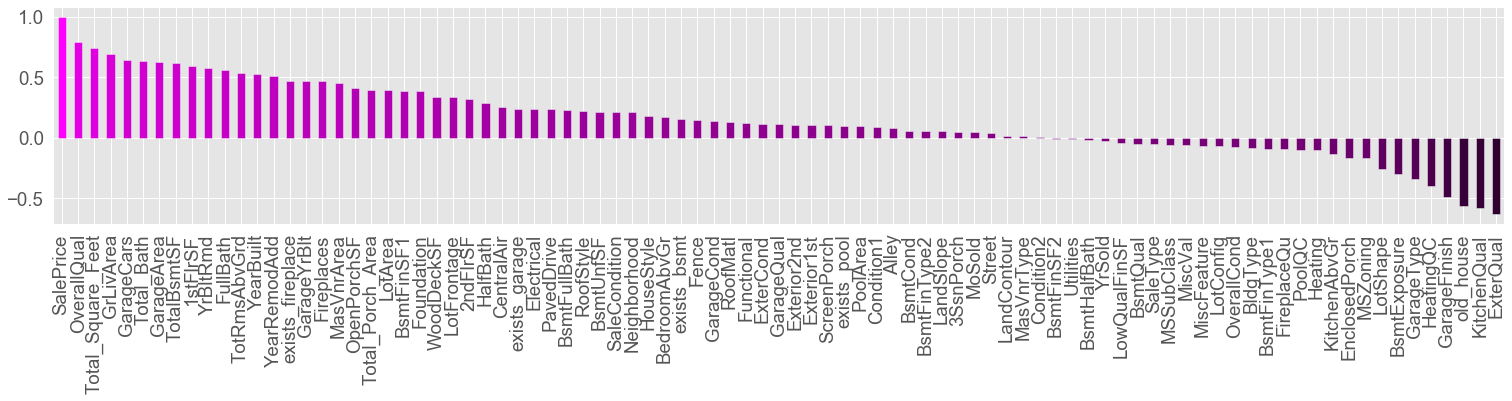

In [16]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(26,4))
cc = train.corrwith(train.SalePrice).sort_values(ascending=False)
mycols = [(0.5*(x+1),0,0.5*(x+1)) for x in cc]
cc.plot(kind='bar', color=mycols);

In [17]:
correlated_cols = []
for ind, value in cc.items() :
    if ((value != 1.0 and value >= 0.4) or value <= -0.3) :
        correlated_cols.append(ind)
print(correlated_cols)
print(len(correlated_cols))

['OverallQual', 'Total_Square_Feet', 'GrLivArea', 'GarageCars', 'Total_Bath', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YrBltRmd', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'exists_fireplace', 'GarageYrBlt', 'Fireplaces', 'MasVnrArea', 'OpenPorchSF', 'GarageType', 'HeatingQC', 'GarageFinish', 'old_house', 'KitchenQual', 'ExterQual']
24


Let's plot some of the highly correlated features and remove outliers in a such a way that boosts correlations (both positive and negative)

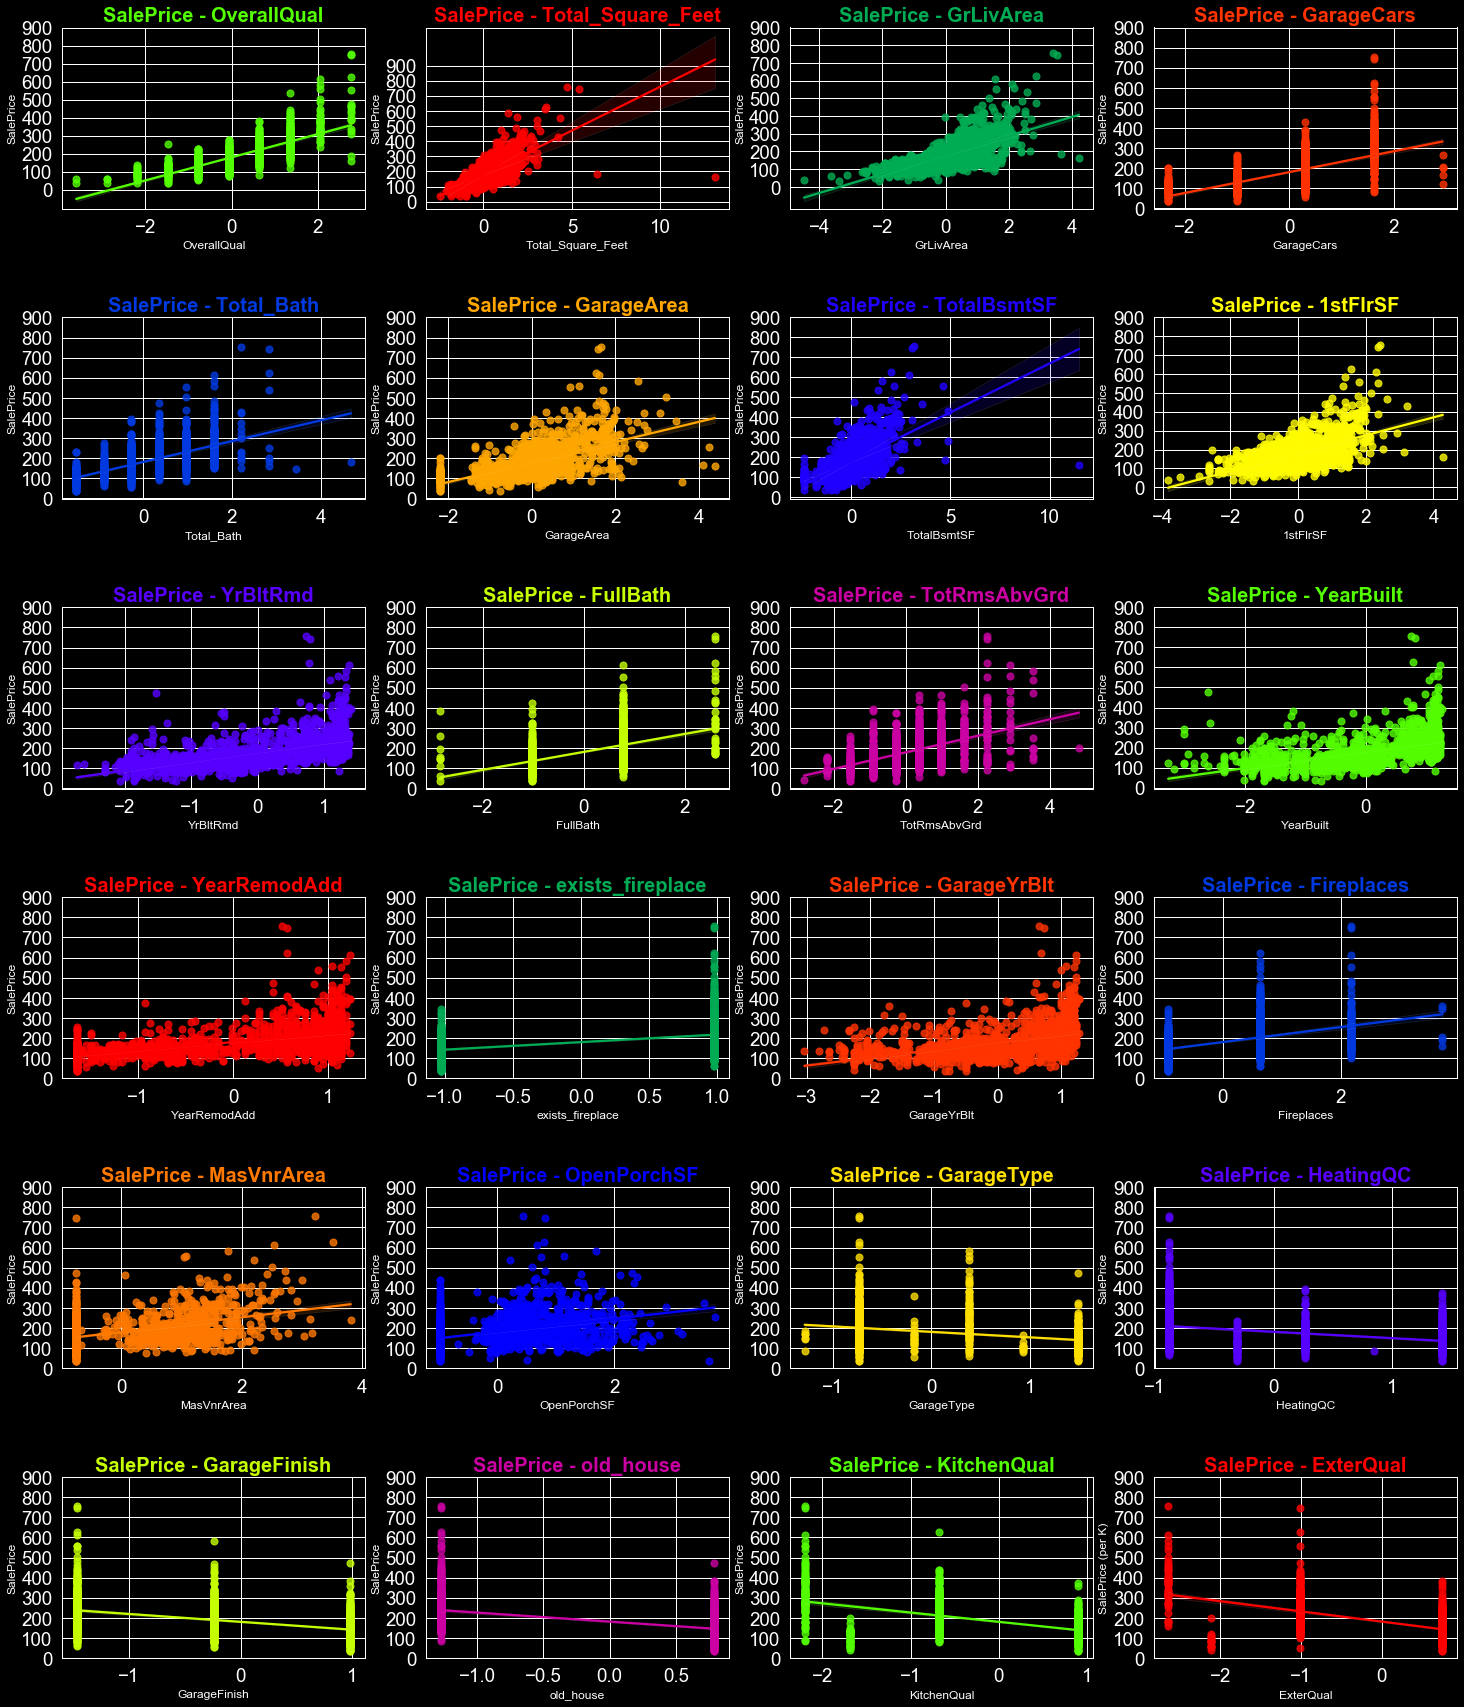

In [19]:
plt.style.use('dark_background')
fig, axes = plt.subplots(6, 4, figsize=(25,30))
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(correlated_cols))]
for cname, ax, color in zip(correlated_cols, axes.flatten(), colors):
    seaborn.regplot(x=train[cname], y=train.SalePrice/1e3, fit_reg=True, marker='o', 
                    scatter_kws={'s':50,'alpha':0.8}, color=color, ax=ax)
    plt.xlabel(cname, fontsize=12)
    plt.ylabel('SalePrice (per K)', fontsize=12)
    ax.set_yticks(np.arange(0,901,100))
    ax.set_title('SalePrice' + ' - ' + str(cname), color=color, fontweight='bold', size=20)

In [20]:
train = train.drop(train[(train.OverallQual>2.5) & (train.SalePrice<200000)].index)
train = train.drop(train[(train.Total_Square_Feet>=5) & (train.SalePrice<200000)].index)
train = train.drop(train[(train.Total_Bath>3) & (train.SalePrice<200000)].index)
train = train.drop(train[(train.GarageArea>3) & (train.SalePrice<165000)].index)
train = train.drop(train[(train.TotalBsmtSF>10)].index)
train = train.drop(train[(train.YearBuilt<-2) & (train.SalePrice>250000)].index)
train = train.drop(train[(train.YearBuilt>0) & (train.SalePrice>600000)].index)
train = train.drop(train[(train.YearRemodAdd<1) & (train.SalePrice>500000)].index)
train = train.drop(train[(train.GarageFinish<0) & (train.SalePrice>500000)].index)
train = train.drop(train[(train.old_house<0) & (train.SalePrice<100000)].index)
train = train.drop(train[(train.old_house>0) & (train.SalePrice>400000)].index)
train = train.drop(train[(train.KitchenQual>0) & (train.SalePrice>360000)].index)
train = train.drop(train[(train.KitchenQual>-1) & (train.SalePrice>600000)].index)
train = train.drop(train[(train.GarageYrBlt<1) & (train.SalePrice>600000)].index)
train = train.drop(train[(train.MasVnrArea>=3) & (train.SalePrice<250000)].index)

#train = train.drop(train[(train.TotRmsAbvGrd==10) & (train.SalePrice>700000)].index)
#train = train.drop(train[(train.Total_Porch_Area>600) & (train.SalePrice<50000)].index)
#train = train.drop(train[(train.LotFrontage>150) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.ExterQual==2) & (train.SalePrice>550000)].index)

#train = train[train.GarageArea * train.GarageCars < 3700]
#train = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]

**comparing correlations before and after outlier removal**

In [21]:
correlations = pd.DataFrame({'old':[], 'new':[], 'diff':[]})
correlations['old'] = cc

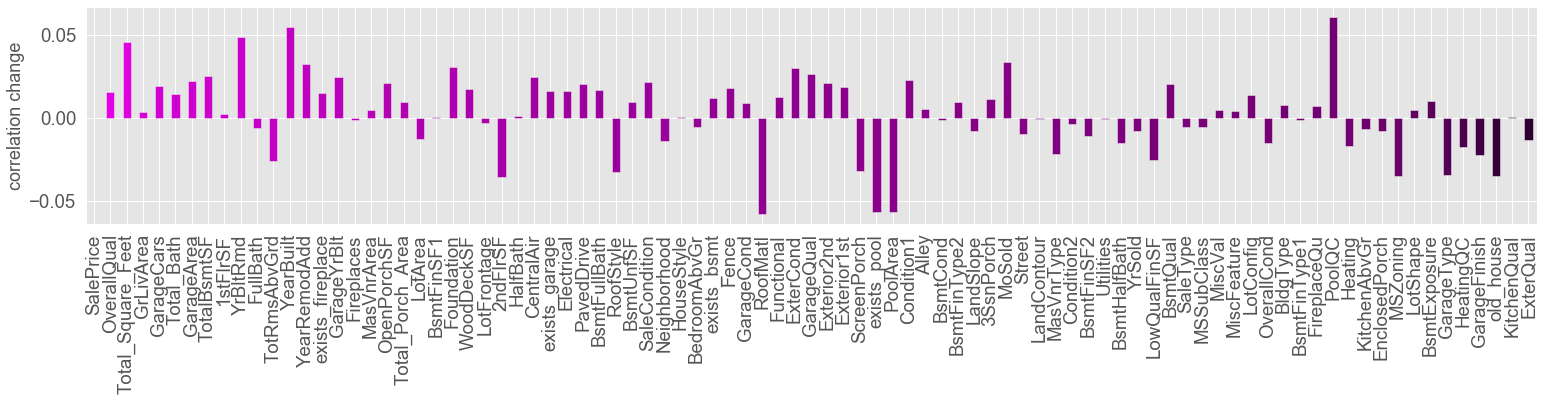

In [26]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(26,4))
correlations['new'] = train.corrwith(train.SalePrice)
correlations['diff'] = correlations['new'] - correlations['old']
correlations.sort_values(by='old', axis=0)

correlations['diff'].plot(kind='bar', color=mycols, ax=ax)
plt.ylabel('correlation change', fontdict={'fontsize':18});

Separate `SalePrice` column, transform to make it more normally distributed, and then z-score it

In [27]:
SalePrice = train.SalePrice
train = train.drop('SalePrice', axis=1)

SalePrice_log1p = np.log1p(SalePrice)

SalePrice_zscore = np.array(SalePrice_log1p).reshape(SalePrice_log1p.shape[0], 1)
mu = SalePrice_log1p.mean()
sigma = SalePrice_log1p.std()
SalePrice_zscore = (SalePrice_log1p - mu)/sigma

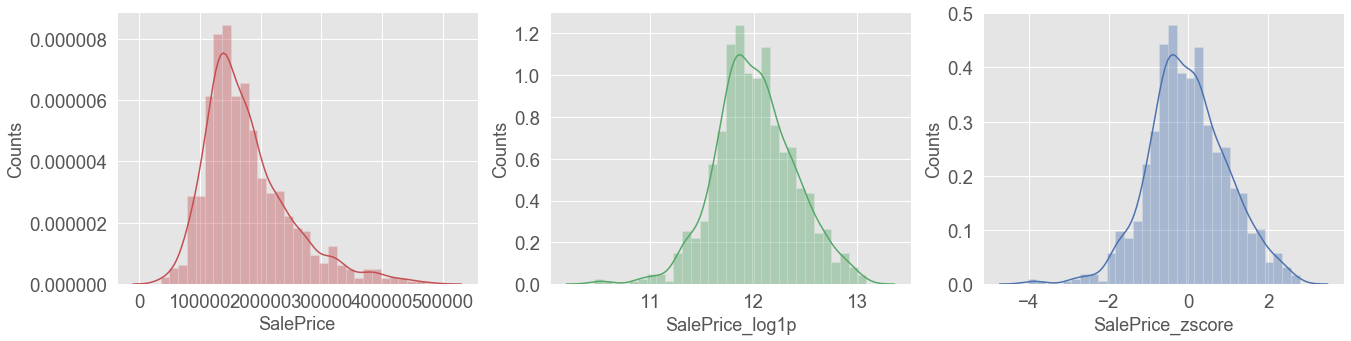

In [29]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(22,5))

ax = plt.subplot(1,3,1)
seaborn.distplot(SalePrice, ax=ax, color='r')
plt.xlabel('SalePrice', fontdict={'fontsize':18})
plt.ylabel('Counts', fontdict={'fontsize':18});

ax = plt.subplot(1,3,2)
seaborn.distplot(SalePrice_log1p, ax=ax, color='g')
plt.xlabel('SalePrice_log1p', fontdict={'fontsize':18})
plt.ylabel('Counts', fontdict={'fontsize':18});

ax = plt.subplot(1,3,3)
seaborn.distplot(SalePrice_zscore, ax=ax, color='b')
plt.xlabel('SalePrice_zscore', fontdict={'fontsize':18})
plt.ylabel('Counts', fontdict={'fontsize':18});

In [32]:
train.interpolate(method='linear',inplace=True)
print('training set size:', train.shape)

training set size: (1435, 88)


In [85]:
def overfit_reducer(df):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

overfitted_features = overfit_reducer(train)

X.drop(overfitted_features,axis=1,inplace=True)
test.drop(overfitted_features,axis=1,inplace=True)

Save 1% of training set as cross-validation set to use it for tuning hyperparameters of the networks e.g. learning rate, number of epochs, number of hidden layers, ...

In [36]:
train = train.to_numpy()
train_x, xvalid_x, train_y, xvalid_y = model_selection.train_test_split(train, SalePrice_zscore, 
                                                                        train_size=0.99, shuffle=True)
print(train_x.shape, train_y.shape, xvalid_x.shape, xvalid_y.shape)

(1420, 88) (1420,) (15, 88) (15,)


# Training regressors

### 1. Gradient Boosting Regressor

In [42]:
gb_reg = GBR(n_estimators=1992, learning_rate=0.033, max_depth=4, max_features='sqrt', 
             min_samples_leaf=15, min_samples_split=14, loss='huber', random_state =42)
gb_reg.fit(train_x, train_y)
pred_y = gb_reg.predict(xvalid_x)
print('R square Accuracy: ', metrics.r2_score(xvalid_y, pred_y))
print('Mean Absolute Error Accuracy: ', metrics.mean_absolute_error(xvalid_y, pred_y))
print('Mean Squared Error Accuracy: ', metrics.mean_squared_error(xvalid_y, pred_y))

R square Accuracy:  0.9867459240630754
Mean Absolute Error Accuracy:  0.09209829472221852
Mean Squared Error Accuracy:  0.012156350838290007


### 2. LassoCV

In [50]:
kfolds = model_selection.KFold(n_splits=8, shuffle=True, random_state=42)
lassocv_reg = make_pipeline(linear_model.LassoCV(alphas=[1e-9,1e-8,1e-7,1e-6], cv=kfolds))
lassocv_reg.fit(train_x, train_y)
pred_y = lassocv_reg.predict(xvalid_x)
print('R square Accuracy: ', metrics.r2_score(xvalid_y, pred_y))
print('Mean Absolute Error Accuracy: ', metrics.mean_absolute_error(xvalid_y, pred_y))
print('Mean Squared Error Accuracy: ', metrics.mean_squared_error(xvalid_y, pred_y))

R square Accuracy:  0.9545894674359701
Mean Absolute Error Accuracy:  0.17358110865063836
Mean Squared Error Accuracy:  0.04164955506736225


### 3. RidgeCV


In [52]:
kfolds = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
ridgecv_reg = make_pipeline(linear_model.RidgeCV(alphas=[1e-9,1e-8,1e-7,1e-6], cv=kfolds))
ridgecv_reg.fit(train_x, train_y)
pred_y = ridgecv_reg.predict(xvalid_x)
print('R square Accuracy: ', metrics.r2_score(xvalid_y, pred_y))
print('Mean Absolute Error Accuracy: ', metrics.mean_absolute_error(xvalid_y, pred_y))
print('Mean Squared Error Accuracy: ', metrics.mean_squared_error(xvalid_y, pred_y))

R square Accuracy:  0.9546233700012489
Mean Absolute Error Accuracy:  0.17335890665163428
Mean Squared Error Accuracy:  0.04161846037016807


### 4. ElasticCV


In [53]:
kfolds = model_selection.KFold(n_splits=8, shuffle=True, random_state=42)
elasticv_reg = make_pipeline(linear_model.ElasticNetCV(alphas=[1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4], 
                                                       cv=kfolds, l1_ratio=[0.87, 0.9, 0.92, 0.95, 0.97, 0.99, 1]))
elasticv_reg.fit(train_x, train_y)
pred_y = elasticv_reg.predict(xvalid_x)
print('R square Accuracy: ', metrics.r2_score(xvalid_y, pred_y))
print('Mean Absolute Error Accuracy: ', metrics.mean_absolute_error(xvalid_y, pred_y))
print('Mean Squared Error Accuracy: ', metrics.mean_squared_error(xvalid_y, pred_y))

R square Accuracy:  0.9547361386874912
Mean Absolute Error Accuracy:  0.17331233965355838
Mean Squared Error Accuracy:  0.041515031378206765


## 5. LightGBM

In [83]:
lgb_reg = lightgbm.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, 
                                 n_estimators=2177, max_bin=50, bagging_fraction=0.65, bagging_freq=5, 
                                 bagging_seed=7, feature_fraction=0.201, feature_fraction_seed=7, n_jobs=-1)
lgb_reg.fit(train_x, train_y)
pred_y = lgb_reg.predict(xvalid_x)
print('R square Accuracy: ', metrics.r2_score(xvalid_y, pred_y))
print('Mean Absolute Error Accuracy: ', metrics.mean_absolute_error(xvalid_y, pred_y))
print('Mean Squared Error Accuracy: ', metrics.mean_squared_error(xvalid_y, pred_y))

R square Accuracy:  0.9710472574597634
Mean Absolute Error Accuracy:  0.12055386415598934
Mean Squared Error Accuracy:  0.026554827188614072


## 6. Stacking Regressors

In [84]:
estimators = [('gbr', gb_reg),   
              ('lasso', lassocv_reg),   
              ('ridge', ridgecv_reg),   
              ('elasticnet', elasticv_reg),
              ('lgb', lgb_reg)]

stack_reg = SR(estimators=estimators, final_estimator=ETR(n_estimators=50), n_jobs=-1)
stack_reg.fit(train_x, train_y)
pred_y = stack_reg.predict(xvalid_x)
print('R square Accuracy: ', metrics.r2_score(xvalid_y, pred_y))
print('Mean Absolute Error Accuracy: ', metrics.mean_absolute_error(xvalid_y, pred_y))
print('Mean Squared Error Accuracy: ', metrics.mean_squared_error(xvalid_y, pred_y))

R square Accuracy:  0.9707582526246771
Mean Absolute Error Accuracy:  0.1340729488514567
Mean Squared Error Accuracy:  0.026819896152002375


Now we are going to clean and preprocess the test dataset just like what we did for the training dataset

In [60]:
#test = df[num_train:]
test.drop('SalePrice', axis=1, inplace=True)
test.interpolate(method='linear', inplace=True)
test.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleCondition,old_house,YrBltRmd,Total_Bath,Total_Square_Feet,Total_Porch_Area,exists_pool,exists_bsmt,exists_fireplace,exists_garage
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1.459000e+03,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,0.006804,-0.000505,-0.026382,-0.032514,-0.000022,-0.031642,0.003634,-0.000595,-1.850900e-02,0.022866,...,0.007876,-0.009437,-0.012065,0.009208,-0.016961,0.011735,-0.005123,-0.010615,-0.027755,0.005975
std,1.007919,1.039482,0.991492,0.974025,1.000342,1.037927,1.000730,0.995669,3.678875e-16,0.988361,...,0.978850,1.002418,1.012187,1.027788,0.989559,1.000533,0.961263,1.030600,1.000538,0.988305
min,-0.981961,-4.596574,-2.773711,-3.328460,-15.561716,-3.789480,-1.381539,-3.942384,-1.850900e-02,-1.904577,...,-3.504814,-1.271764,-2.396426,-1.506988,-2.213857,-1.520058,-0.066873,-5.994752,-1.027264,-4.179557
25%,-0.981961,-0.043158,-0.410056,-0.387180,0.064238,0.055321,-1.381539,0.316616,-1.850900e-02,-0.658061,...,0.204932,-1.271764,-0.814373,-0.888383,-0.662023,-0.765100,-0.066873,0.166755,-1.027264,0.239178
50%,-0.061343,-0.043158,0.020207,0.085025,0.064238,0.055321,0.746541,0.316616,-1.850900e-02,0.588455,...,0.204932,0.786040,-0.034182,-0.269779,-0.173027,0.096609,-0.066873,0.166755,-1.027264,0.239178
75%,0.398966,-0.043158,0.551124,0.491752,0.064238,0.055321,0.746541,0.316616,-1.850900e-02,0.588455,...,0.204932,0.786040,1.006072,0.967431,0.476079,0.668014,-0.066873,0.166755,0.973126,0.239178
max,2.470357,1.474647,4.481922,3.924553,0.064238,3.900121,0.746541,0.316616,-1.850900e-02,0.588455,...,1.132369,0.786040,1.396168,5.916268,10.182568,4.667814,14.948641,0.166755,0.973126,0.239178


## Compare and combine regressors for the final prediction

In [99]:
pred_df = pd.read_csv('sample_submission.csv')

pred_y = gb_reg.predict(test)*sigma + mu
pred_df['GBR'] = np.floor(np.expm1(pred_y))

pred_y = lassocv_reg.predict(test)*sigma + mu
pred_df['LassoCV'] = np.floor(np.expm1(pred_y))

pred_y = ridgecv_reg.predict(test)*sigma + mu
pred_df['RidgeCV'] = np.floor(np.expm1(pred_y))

pred_y = elasticv_reg.predict(test)*sigma + mu
pred_df['ElasticCV'] = np.floor(np.expm1(pred_y))

pred_y = lgb_reg.predict(test)*sigma + mu
pred_df['LGBM'] = np.floor(np.expm1(pred_y))

pred_y = stack_reg.predict(test)*sigma + mu
pred_df['SR'] = np.floor(np.expm1(pred_y))

pred_df['combined'] = (pred_df['SR']*0.1665 + pred_df['LGBM']*0.678 + pred_df['RidgeCV']*0.1665)

pred_df.head(10)

,Id,SalePrice,GBR,LassoCV,RidgeCV,ElasticCV,LGBM,SR,combined
0,1461,169277.052498,126159.0,121472.0,121590.0,121358.0,123190.0,129438.0,125318.9820
1,1462,187758.393989,156988.0,156706.0,156138.0,158280.0,155977.0,156736.0,157845.9270
2,1463,183583.683570,184380.0,180924.0,180908.0,181064.0,182511.0,176350.0,183225.9150
3,1464,179317.477511,193913.0,201111.0,200925.0,201197.0,197160.0,190734.0,198885.7035
4,1465,150730.079977,186413.0,194688.0,194777.0,194270.0,187590.0,188686.0,191032.6095
5,1466,177150.989247,177689.0,170214.0,170224.0,170348.0,173941.0,164977.0,173742.9645
6,1467,172070.659229,172061.0,181354.0,181319.0,181354.0,177296.0,155489.0,176285.2200
7,1468,175110.956520,167801.0,159218.0,159231.0,159526.0,166974.0,169451.0,167933.9250
8,1469,162011.698832,173369.0,192135.0,192025.0,192368.0,171685.0,164550.0,175772.1675
9,1470,160726.247831,128230.0,114708.0,114701.0,114894.0,127476.0,83051.0,119354.4360


Submission file contains house IDs that are in the test set. Save the predicted prices to submit to kaggle.

In [100]:
submission = pd.read_csv('sample_submission.csv')
submission.SalePrice = pred_df['combined']
submission.to_csv ('submission.csv', index = None, header = True)